In [9]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import pandas as pd
import os
from PIL import Image as Img
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [10]:
drive = r"./data/"
PATH_GRANDE = drive+r"ModeloFinalGrande_trans.pt"
PATH_PARCIAL = drive+r"ModeloFinalParcial.pt"
datos_origen = drive+r"eval.csv"

In [11]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [12]:
# Carga del modelo grande
model_grande = torch.load(PATH_GRANDE).to(device)
model_parcial = torch.load(PATH_PARCIAL).to(device)

# 1. Creacion de las clases de dataset para cargar los datos

In [13]:
class ComidasDatasetGeneral(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, index_col=0)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Img.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)


        return image, idx

class ComidasDatasetEspecifico(Dataset):
    def __init__(self, data, img_dir, transform=None, target_transform=None):
        self.img_labels = data
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        index = self.img_labels.iloc[idx, 0]
        image = Img.open(img_path).convert('RGB')
        
        
        if self.transform:
            image = self.transform(image)


        return image, index

In [14]:
transform_test = transforms.Compose([
    transforms.Resize(size=(300,300)),
    transforms.ToTensor(),
])

In [15]:
dat_eval = ComidasDatasetGeneral(datos_origen, drive, transform=transform_test )
eval_dataloader = DataLoader(dat_eval, batch_size=100, shuffle=False)

# 2. Se aplica el primer clasificador
- 0 = Burger(0) Bocata(6)
- 1 = Pollo
- 2 = Donut
- 3 = Fries
- 4 = HotDog(4) Patata(7)
- 5 = Pizza

In [16]:
torch.cuda.empty_cache()

preds = {"target":{}}
y_pred = []
labels=[]

# iterate over test data
for inputs, idx in eval_dataloader:
        inputs = inputs.to(device)
        output = model_grande(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        idx = idx.data.cpu().numpy()
        tuplas = zip(idx,output)
        
        # preds["target"][f"{idx[0]}"]=int(output[0])

        y_pred.extend(tuplas) # Save Prediction

        labels.extend(output)

/home/asl1014/miniconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


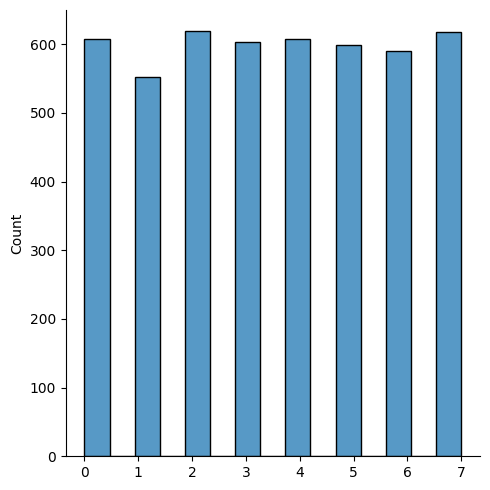

In [17]:
sns.displot(labels)

In [18]:
# coger de eval solo las imagenes con labael 0 o 4
datos = pd.DataFrame(y_pred, columns=["idx","label"])
original = pd.read_csv(drive+r"eval.csv", index_col=0)
repasar = pd.DataFrame()

In [19]:
dic =  datos.to_dict('records')

final = dict()
for row in dic:
    final[str(row['idx'])] = row['label']


preds = {"target":final}

with open(drive+r"results.json", "w") as results:
        json.dump(preds, results, indent=4)

In [12]:
len(original)

4797

In [13]:
repasar = datos.query("label == 0 or label == 4")

In [14]:
pendiente_mod = []

for fila in repasar.iterrows():
    pendiente_mod.append((fila[0], original.iloc[fila[0],0]))

In [15]:
df_definitivo = pd.DataFrame(data=pendiente_mod, columns=["idx","path_img"] )

In [16]:
dat_defi = ComidasDatasetEspecifico(df_definitivo, drive, transform=transform_test )
defi_dataloader = DataLoader(dat_defi, batch_size=100, shuffle=False)

In [17]:
train = iter(dat_defi)

0


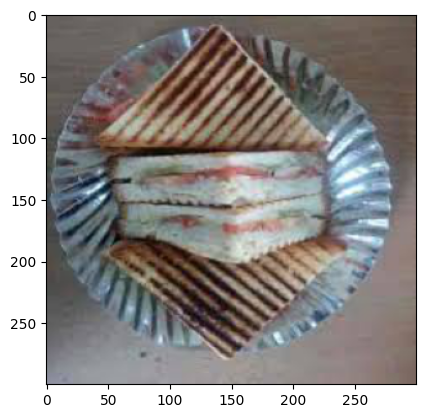

In [18]:
img, index = next(train)

plt.imshow(img.permute(1, 2, 0))
print(index)

# 3. Usamos el siguiente clasificador sobre el set que hay que re clasificar

In [19]:
df_definitivo.iloc[0,0]

0

In [20]:
y_pred = []
labels = []
# iterate over test data
for inputs, idx in defi_dataloader:
        inputs = inputs.to(device)
        output = model_parcial(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        idx = idx.data.cpu().numpy()
        tuplas = zip(idx,output)
        
        # preds["target"][f"{idx[0]}"]=int(output[0])
        labels.extend(output)
        y_pred.extend(tuplas) # Save Prediction

/home/asl1014/miniconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


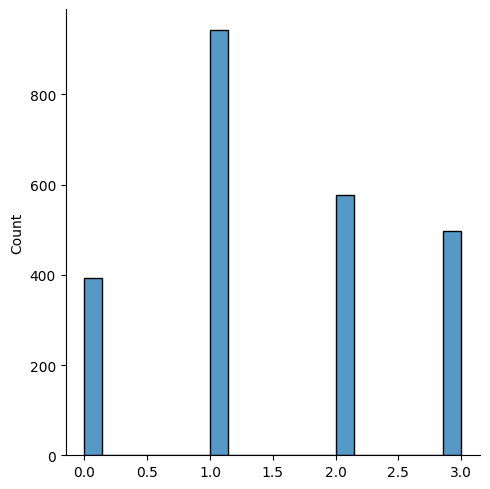

In [21]:
sns.displot(labels)

In [22]:
datos

,idx,label
0,0,0
1,1,2
2,2,0
3,3,0
4,4,5
...,...,...
4792,4792,1
4793,4793,2
4794,4794,3
4795,4795,4


In [23]:
# actualizar datos en original

datos_mod = datos.copy()

transformacion = {1:6,2:4,3:7,0:0}

for tupla in y_pred:
    datos_mod.loc[tupla[0]]['label'] =  transformacion.get(tupla[1])
    #datos.set_values(tupla[0],'label',transformacion.get(tupla[1]))

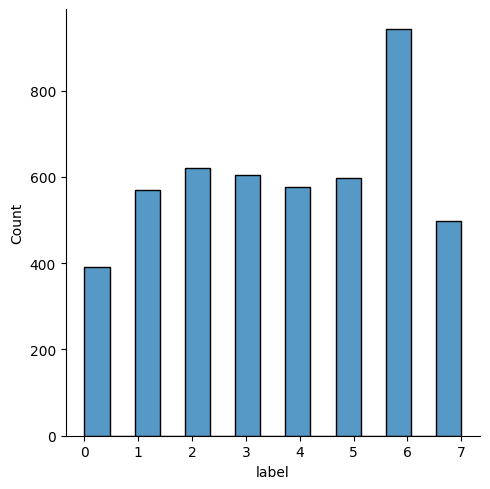

In [24]:
sns.displot(datos_mod['label'])

In [29]:
dic =  datos_mod.to_dict('records')

In [30]:
final = dict()
for row in dic:
    final[str(row['idx'])] = row['label']


In [31]:
preds = {"target":final}

In [32]:
with open(drive+r"results.json", "w") as results:
        json.dump(preds, results, indent=4)
